<a href="https://colab.research.google.com/github/henselrj/UMDAOSC650-Hensel/blob/main/AOSC_HW3_Optimization_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import shap

In [6]:
!pip install keras-tuner -q
import keras_tuner as kt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [8]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = '123'

In [9]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('PALMO_dataset_formatted.csv')

Saving PALMO_dataset_formatted.csv to PALMO_dataset_formatted.csv


In [10]:
df = df.dropna()
scaler = StandardScaler()
df[['cl', 'cd', 'cm']] = scaler.fit_transform(df[['cl', 'cd', 'cm']])
df['cl_cd'] = df['cl'] / df['cd']

<ipython-input-10-21ec346ef07e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['cl', 'cd', 'cm']] = scaler.fit_transform(df[['cl', 'cd', 'cm']])
<ipython-input-10-21ec346ef07e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cl_cd'] = df['cl'] / df['cd']


In [11]:
df['NACA_code'] = (
    df['Camber'].astype(int).astype(str).str.zfill(1) +
    df['Camber_Location'].astype(int).astype(str).str.zfill(1) +
    df['Thickness'].astype(int).astype(str).str.zfill(2)
)

In [12]:
unique_naca = sorted(df['NACA_code'].unique())
naca_map = {v: i for i, v in enumerate(unique_naca)}
df['NACA_class'] = df['NACA_code'].map(naca_map)

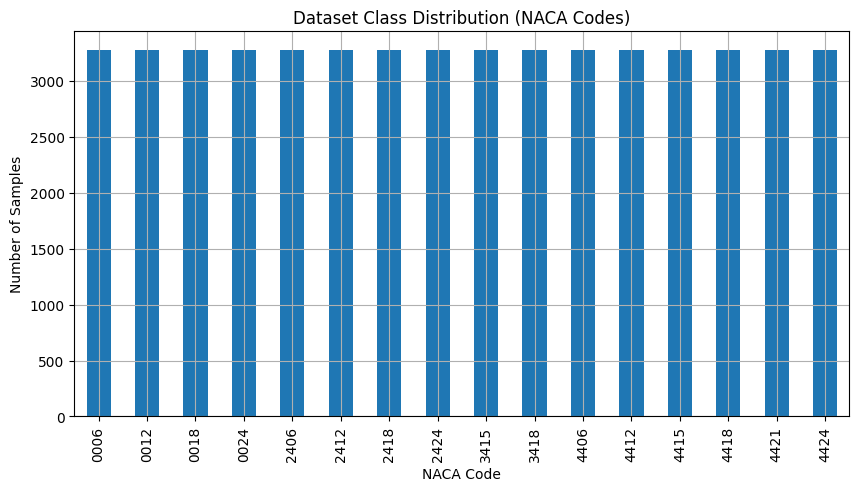

NACA_code
0006    3279
0012    3280
0018    3280
0024    3280
2406    3280
2412    3280
2418    3280
2424    3280
3415    3280
3418    3279
4406    3280
4412    3280
4415    3280
4418    3280
4421    3280
4424    3280
Name: count, dtype: int64


In [13]:
# Data Visualization
naca_counts = df['NACA_code'].value_counts().sort_index()

naca_counts.plot(kind='bar', figsize=(10,5), title='Dataset Class Distribution (NACA Codes)')
plt.xlabel('NACA Code')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

print(naca_counts)

In [22]:
# Setup for Feature Analysis
features_to_test = ['Re', 'Mach', 'cl', 'cd', 'cm', 'cl_cd']
X = df[features_to_test].dropna().values
y = df['NACA_class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

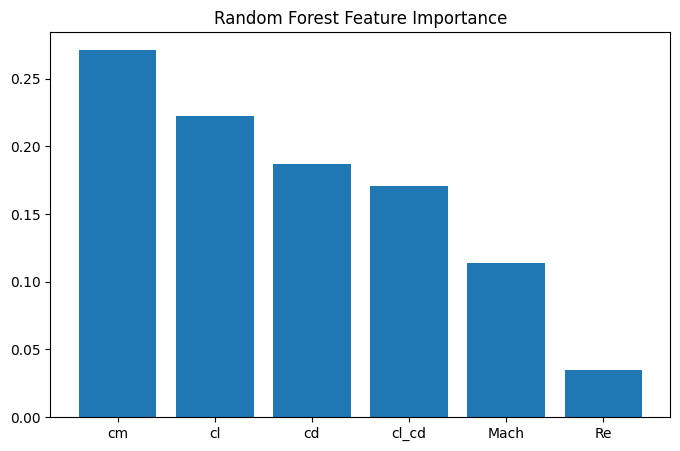

In [23]:
# Random Forest Analysis
rf = RandomForestClassifier(n_estimators=100, random_state=123)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Random Forest Feature Importance")
plt.bar(range(X.shape[1]), importances[indices], tick_label=np.array(features_to_test)[indices])
plt.show()

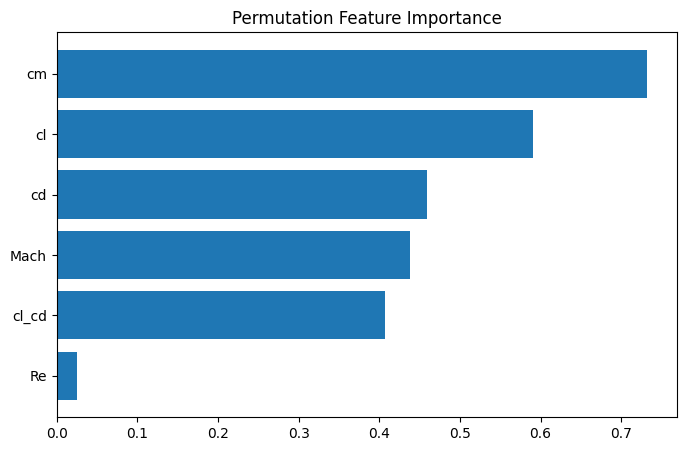

In [24]:
# Permutation Analysis
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=123)
perm_sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 5))
plt.title("Permutation Feature Importance")
plt.barh(range(X.shape[1]), perm_importance.importances_mean[perm_sorted_idx], tick_label=np.array(features_to_test)[perm_sorted_idx])
plt.show()

In [26]:
from keras.losses import CategoricalFocalCrossentropy

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=CategoricalFocalCrossentropy(gamma=3.0, alpha=0.5),
    metrics=['accuracy']
)

In [27]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


 Current Feature Set Being Tested: Baseline --> ['cl', 'cd', 'cm']
Final Val Accuracy (Baseline): 0.5241

 Current Feature Set Being Tested: Extended_Aero --> ['cl', 'cd', 'cm', 'cl_cd']
Final Val Accuracy (Extended_Aero): 0.4090

 Current Feature Set Being Tested: Flow_Performance --> ['Re', 'Mach', 'cl', 'cd', 'cm', 'cl_cd']
Final Val Accuracy (Flow_Performance): 0.0599


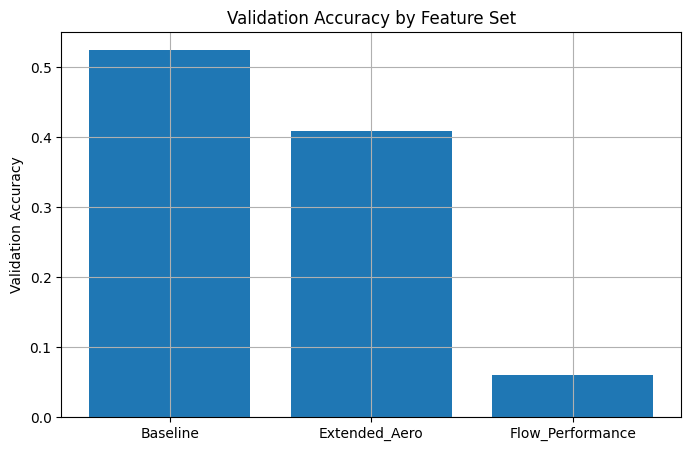

        Feature_Set  Val_Accuracy
0          Baseline      0.524116
1     Extended_Aero      0.408956
2  Flow_Performance      0.059902


In [34]:
# Feature Set Analysis
feature_sets = {
    'Baseline': ['cl', 'cd', 'cm'],
    'Extended_Aero': ['cl', 'cd', 'cm', 'cl_cd'],
    'Flow_Performance': ['Re', 'Mach', 'cl', 'cd', 'cm', 'cl_cd']
}

results = []

for name, features in feature_sets.items():
    print(f"\n Current Feature Set Being Tested: {name} --> {features}")

    if 'cl_cd' in features:
        df['cl_cd'] = df['cl'] / df['cd']

    X = df[features].values
    y = df['NACA_class'].values
    y_oh = keras.utils.to_categorical(y, num_classes=len(naca_map))

    X_train, X_test, y_train, y_test = train_test_split(X, y_oh, test_size=0.2, random_state=123)

    input_layer = keras.Input(shape=(X.shape[1],))
    x = layers.Dense(256, activation='relu')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    output_layer = layers.Dense(len(naca_map), activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=keras.losses.CategoricalFocalCrossentropy(gamma=3.0, alpha=0.5),
        metrics=['accuracy']
    )

    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=16,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    final_val_acc = history.history['val_accuracy'][-1]
    print(f"Final Val Accuracy ({name}): {final_val_acc:.4f}")
    results.append({
        'Feature_Set': name,
        'Val_Accuracy': final_val_acc
    })

df_results = pd.DataFrame(results)
plt.figure(figsize=(8,5))
plt.bar(df_results['Feature_Set'], df_results['Val_Accuracy'])
plt.title('Validation Accuracy by Feature Set')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.show()

print(df_results)

In [30]:
X = df[['cl', 'cd', 'cm']].values
y = df['NACA_class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [31]:
y_train_oh = keras.utils.to_categorical(y_train, num_classes=len(naca_map))
y_test_oh = keras.utils.to_categorical(y_test, num_classes=len(naca_map))

In [32]:
input_layer = keras.Input(shape=(3,))
x = layers.Dense(256, activation='relu')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output_layer = layers.Dense(len(naca_map), activation='softmax')(x)


Training with gamma=2.0, alpha=0
Final Val Accuracy: 0.0624

Training with gamma=2.0, alpha=0.25
Final Val Accuracy: 0.5386

Training with gamma=2.0, alpha=0.5
Final Val Accuracy: 0.5270

Training with gamma=3.0, alpha=0
Final Val Accuracy: 0.0606

Training with gamma=3.0, alpha=0.25
Final Val Accuracy: 0.5439

Training with gamma=3.0, alpha=0.5
Final Val Accuracy: 0.5279

Training with gamma=4.0, alpha=0
Final Val Accuracy: 0.0786

Training with gamma=4.0, alpha=0.25
Final Val Accuracy: 0.5270

Training with gamma=4.0, alpha=0.5
Final Val Accuracy: 0.5265


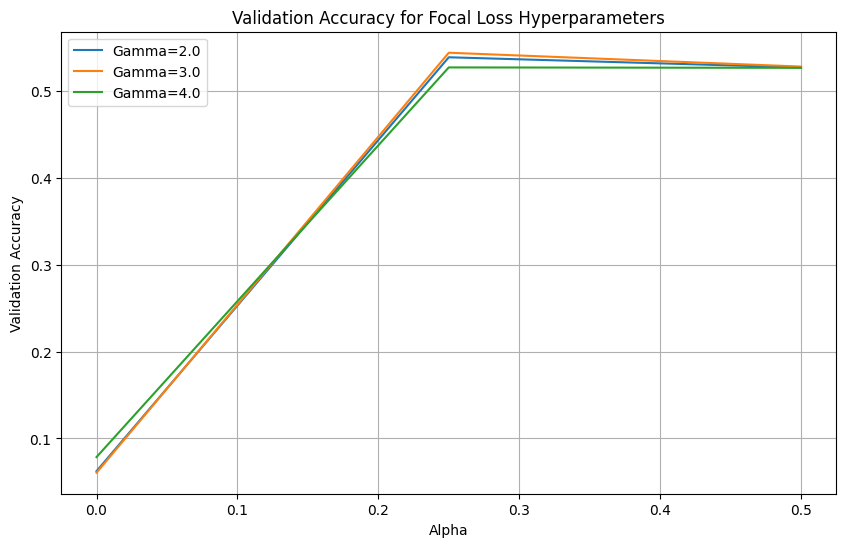

   gamma  alpha  val_accuracy
0    2.0   0.00      0.062403
1    2.0   0.25      0.538645
2    2.0   0.50      0.526974
3    3.0   0.00      0.060617
4    3.0   0.25      0.543885
5    3.0   0.50      0.527927
6    4.0   0.00      0.078599
7    4.0   0.25      0.526974
8    4.0   0.50      0.526498


In [33]:
# Grid Search for gamma and alpha values
from keras.losses import CategoricalFocalCrossentropy

gammas = [2.0, 3.0, 4.0]
alphas = [0, 0.25, 0.5]

results = []

for gamma in gammas:
    for alpha in alphas:
        print(f"\nTraining with gamma={gamma}, alpha={alpha}")

        input_layer = keras.Input(shape=(3,))
        x = layers.Dense(256, activation='relu')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
        output_layer = layers.Dense(len(naca_map), activation='softmax')(x)
        model = keras.Model(inputs=input_layer, outputs=output_layer)

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-4),
            loss=CategoricalFocalCrossentropy(gamma=gamma, alpha=alpha),
            metrics=['accuracy']
        )

        history = model.fit(
            X_train, y_train_oh,
            validation_split=0.2,
            epochs=30,
            batch_size=16,
            callbacks=[early_stop, reduce_lr],
            verbose=0
        )

        final_val_acc = history.history['val_accuracy'][-1]
        print(f"Final Val Accuracy: {final_val_acc:.4f}")
        results.append({
            'gamma': gamma,
            'alpha': alpha if alpha is not None else 'None',
            'val_accuracy': final_val_acc
        })

import pandas as pd

df_results = pd.DataFrame(results)
plt.figure(figsize=(10,6))
for gamma in gammas:
    subset = df_results[df_results['gamma'] == gamma]
    plt.plot(subset['alpha'], subset['val_accuracy'], label=f'Gamma={gamma}')
plt.title('Validation Accuracy for Focal Loss Hyperparameters')
plt.xlabel('Alpha')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print(df_results)

In [14]:
X = df[['cl', 'cd', 'cm']].values
y = df['NACA_class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [17]:
y_train_oh = keras.utils.to_categorical(y_train, num_classes=len(naca_map))
y_test_oh = keras.utils.to_categorical(y_test, num_classes=len(naca_map))

In [21]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X.shape[1],)))

    # Tune number of hidden layers (1 to 4) and units per layer (64 to 512)
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
            activation='relu'
        ))
        if hp.Boolean(f'dropout_{i}'):
            model.add(layers.Dropout(0.2))

    model.add(layers.Dense(len(naca_map), activation='softmax'))

    # Tune learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')
        ),
        loss=keras.losses.CategoricalFocalCrossentropy(gamma=3.0, alpha=0.5),
        metrics=['accuracy']
    )
    return model

# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='tuning_dir',
    project_name='airfoil_tuning'
)

# Search best hyperparameters
tuner.search(X_train, y_train_oh, validation_split=0.2, epochs=30, batch_size=32)

# Retrieve best model and hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of layers: {best_hps.get('num_layers')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
for i in range(best_hps.get('num_layers')):
    print(f"Best units in layer {i}: {best_hps.get(f'units_{i}')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train_oh, validation_split=0.2, epochs=50, batch_size=32)

# Evaluate on test set
test_results = best_model.evaluate(X_test, y_test_oh)
print(f"Test Accuracy: {test_results[1]:.4f}")


Reloading Tuner from tuning_dir/airfoil_tuning/tuner0.json
Best number of layers: 3
Best learning rate: 0.0005227316838512897
Best units in layer 0: 512
Best units in layer 1: 192
Best units in layer 2: 320
Epoch 1/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.1775 - loss: 0.8922 - val_accuracy: 0.3464 - val_loss: 0.5522
Epoch 2/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3206 - loss: 0.5638 - val_accuracy: 0.4207 - val_loss: 0.4401
Epoch 3/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.3734 - loss: 0.4686 - val_accuracy: 0.4431 - val_loss: 0.3887
Epoch 4/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.4091 - loss: 0.4170 - val_accuracy: 0.4866 - val_loss: 0.3449
Epoch 5/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4430 - loss: 0.3827 - val_accuracy: 0.5153 - val_loss: 0.3165
Epoch 6/50
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4673 - loss: 0.3555 - val_accuracy: 0.5311 - val_loss: 0.2953
Epoch 7/5